In [1]:
%pwd

'/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity(2)/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/TCGA.CRCvsHC'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/TCGA.CRCvsHC/TCGA.CRCvsHC.csv', index_col=0)

In [3]:
df = df.replace([np.inf, -np.inf], np.nan)
cols_to_fillna = df.columns[2:]
df[cols_to_fillna] = df[cols_to_fillna].fillna(df[cols_to_fillna].mean())
#df.drop(df.columns[0], axis=1, inplace=True)
print(df.info())
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, tcga.a6.2671 to tcga.g5.6641
Columns: 20503 entries, group to tAKR.389932
dtypes: float64(20075), int64(428)
memory usage: 67.3+ MB
None


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
X = df.iloc[:, 1:]  # 特征
y = df['group']  # 标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(y_train.shape)
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

2024-12-29 02:08:41.611798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(387,)


In [11]:
import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation
def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3,
                activation='relu', regularization=None, reg_strength=1e-4, batch_size=32):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation=activation, input_shape=(X_train.shape[1],)))
    
    # 添加正则化
    if regularization is not None:
        if regularization == 'l1':
            reg = keras.regularizers.l1(reg_strength)
        elif regularization == 'l2':
            reg = keras.regularizers.l2(reg_strength)
        else:
            raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")
        model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
    else:
        model.add(keras.layers.Dense(layer_size, activation=activation))
    
    for _ in range(hidden_layers-1):
        # 添加正则化
        if regularization is not None:
            model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
        else:
            model.add(keras.layers.Dense(layer_size, activation=activation))
    
    model.add(keras.layers.Dense(2))
    model.add(Activation('softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(X_train_normalized, y_train_one_hot,
                            epochs = 20,
                            validation_data=(X_test_normalized,y_test_one_hot), 
                            #callbacks=callbacks,
                            verbose=0)

/var/folders/xm/v410f3rx60n6h8209h6jtpww0000gn/T/ipykernel_46163/2970698520.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)


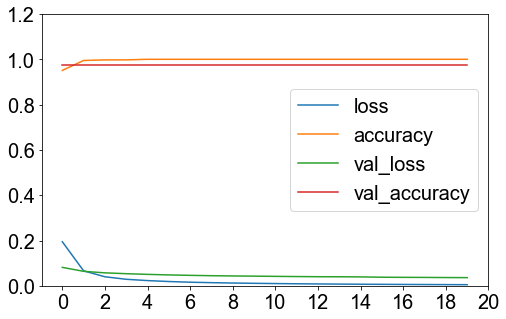

2/2 [==============================] - 0s 9ms/step - loss: 0.0361 - accuracy: 0.9767
Test Accuracy: 0.9767441749572754
2/2 [==============================] - 0s 11ms/step
AUC Scores: [1. 1.]


In [15]:
def plot_learning_curves(history):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib import rcParams
    from matplotlib.backends.backend_pdf import PdfPages

    # Ensure fonts are embedded
    rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts for embedding
    rcParams['font.family'] = 'Arial'
    
    # Plot learning curves
    fig, ax = plt.subplots(figsize=(8, 5))
    pd.DataFrame(history.history).plot(ax=ax)
    
    # Customize the plot
    ax.grid(False)
    ax.set_ylim(0, 1.2)
    
    # Set x-axis ticks from 0, with interval of 25
    max_epochs = len(history.history['loss'])
    ax.set_xticks(range(0, max_epochs + 1, 2))  # Adjust interval to 25
    
    ax.tick_params(labelsize=20)  # Set font size for ticks
    ax.legend(loc='right', fontsize=20)  # Set font size for legend
    
    # Save as an editable PDF with embedded fonts
    with PdfPages('learning_curves.pdf') as pdf:
        pdf.savefig(fig, bbox_inches='tight')
    
    plt.show()
plot_learning_curves(history)
test_accuracy = sklearn_model.score(X_test_normalized, y_test_one_hot)
print("Test Accuracy:", test_accuracy)
from sklearn.metrics import roc_auc_score
y_pred_prob = sklearn_model.predict_proba(X_test_normalized)
auc_scores = roc_auc_score(y_test_one_hot, y_pred_prob, average=None)
print("AUC Scores:", auc_scores)

In [20]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribution = {
    'hidden_layers': [1, 2, 3, 4, 5],
    'layer_size': np.arange(1, 128),  
    'learning_rate': reciprocal(1e-4, 1e-2),
    'activation': ['relu', 'tanh'],  
    'regularization': [None, 'l1', 'l2'],  # 正则化的选择范围
    'reg_strength': reciprocal(1e-6, 1),  # 正则化强度的选择范围
    'batch_size': [16, 32, 64, 128]  
}
# 创建神经网络模型
random_search_cv = RandomizedSearchCV(sklearn_model,
                                     param_distribution,
                                     n_iter = 10,
                                     cv =5,
                                     n_jobs =1)

random_search_cv.fit(X_train_normalized, y_train_one_hot, epochs = 10,
                    validation_data = (X_test_normalized, y_test_one_hot),
                    callbacks = callbacks, verbose=0)

print(f'Best parameters: {random_search_cv.best_params_}')
print(f'Best cross-validation score: {random_search_cv.best_score_}')

3/3 [==============================] - 0s 5ms/step - loss: 1.8837 - accuracy: 0.9870
Best parameters: {'activation': 'relu', 'batch_size': 32, 'hidden_layers': 1, 'layer_size': 73, 'learning_rate': 0.002632609060082567, 'reg_strength': 0.024794320752896417, 'regularization': 'l2'}
Best cross-validation score: 0.9948384881019592
Best parameters: {'activation': 'relu', 'batch_size': 32, 'hidden_layers': 1, 'layer_size': 73, 'learning_rate': 0.002632609060082567, 'reg_strength': 0.024794320752896417, 'regularization': 'l2'}
Best cross-validation score: 0.9948384881019592


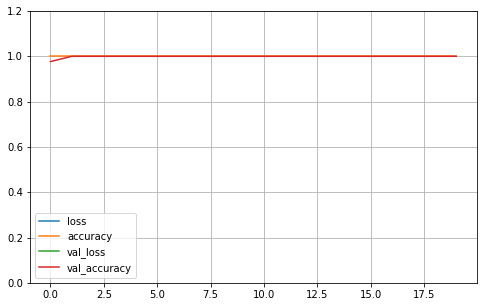

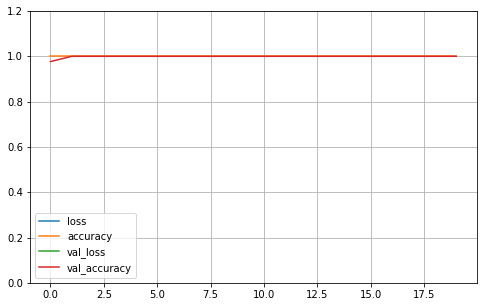

2/2 [==============================] - 0s 6ms/step - loss: 1.6369 - accuracy: 1.0000


[1.6369273662567139, 1.0]

[1.6369273662567139, 1.0]

In [21]:
best_model = random_search_cv.best_estimator_.model
optimization = best_model.fit(X_train_normalized, y_train_one_hot,
                                 epochs=20,
                                 validation_data=(X_test_normalized, y_test_one_hot),
                                 verbose=0)
plot_learning_curves(optimization)
best_model.evaluate(X_test_normalized,y_test_one_hot)

In [22]:
from sklearn.metrics import roc_auc_score
y_pred_prob = best_model.predict(X_test_normalized)
auc_scores = roc_auc_score(y_test_one_hot, y_pred_prob, average=None)
print("AUC Scores:", auc_scores)

2/2 [==============================] - 0s 4ms/step
AUC Scores: [1. 1.]
AUC Scores: [1. 1.]


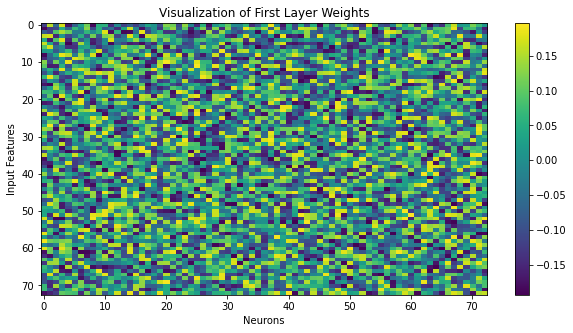

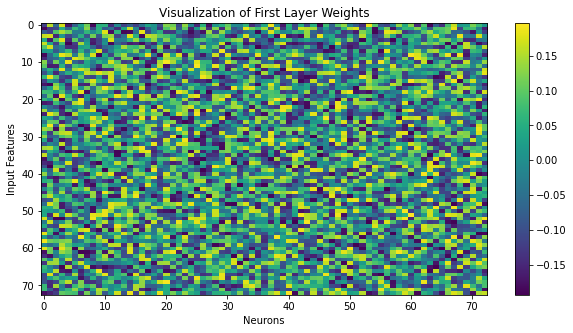

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt

weights = best_model.layers[1].get_weights()[0]

# 可视化权重
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title('Visualization of First Layer Weights')
plt.imshow(weights, cmap='viridis', aspect='auto')  # aspect='auto'用于自动调整纵横比
plt.colorbar()
plt.ylabel('Input Features')  # 纠正横轴标签为 'Input Features'
plt.xlabel('Neurons')  # 纠正纵轴标签为 'Neurons'
plt.show()

13/13 [==============================] - 0s 3ms/step


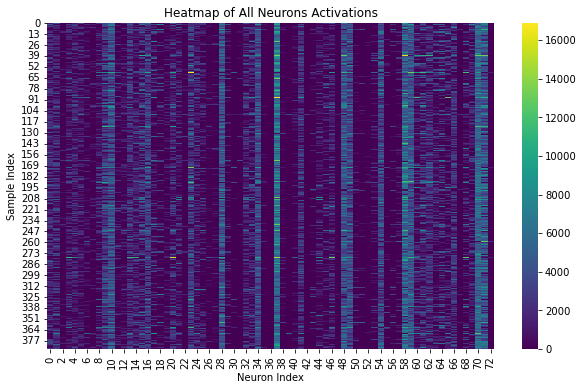

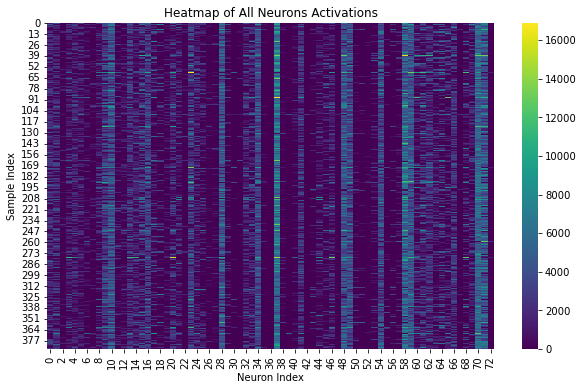

In [24]:
# Visualize activation values
import numpy as np
import seaborn as sns

activation_model = tf.keras.models.Model(inputs=best_model.input, outputs=best_model.layers[1].output)  # Assuming you want to visualize activations of the first hidden layer
activations = activation_model.predict(X_train)
combined_activations = np.vstack(activations)
# 绘制所有神经元的激活值热力图
plt.figure(figsize=(10, 6))
sns.heatmap(combined_activations, cmap='viridis')
plt.title('Heatmap of All Neurons Activations')
plt.xlabel('Neuron Index')
plt.ylabel('Sample Index')
plt.show()

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf

# 假设X_train_normalized是你的标准化后的训练集特征数据，y_train是对应的标签数据
# 获取特征列名
feature_names = X_train.columns.tolist()


# 获取模型每一层的权重
layer_weights = [layer.get_weights()[0] for layer in best_model.layers if layer.get_weights()]

# 重新调整权重的形状，使它们具有相同的特征维度
max_features = max(weights.shape[0] for weights in layer_weights)
adjusted_layer_weights = [np.pad(weights, ((0, max_features - weights.shape[0]), (0, 0)), mode='constant') for weights in layer_weights]

# 计算每个特征的平均权重
feature_weights = np.mean(np.abs(np.hstack(adjusted_layer_weights)), axis=1)

# 创建特征重要性DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_weights})

# 按照特征重要性降序排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 打印排序后的特征重要性
print(feature_importance_df)

              Feature  Importance
62     ABCC6P1.653190    0.059969
5               A2M.2    0.059910
48       ABCB5.340273    0.059356
52        ABCB9.23457    0.058348
35           ABCA1.19    0.058231
...               ...         ...
14951    RIMBP3.85376    0.003279
14925        RHOG.391    0.003241
681    ANKRD33.341405    0.003207
2892       CAMK2B.816    0.003182
11903     NLRP2.55655    0.003106

[20502 rows x 2 columns]
              Feature  Importance
62     ABCC6P1.653190    0.059969
5               A2M.2    0.059910
48       ABCB5.340273    0.059356
52        ABCB9.23457    0.058348
35           ABCA1.19    0.058231
...               ...         ...
14951    RIMBP3.85376    0.003279
14925        RHOG.391    0.003241
681    ANKRD33.341405    0.003207
2892       CAMK2B.816    0.003182
11903     NLRP2.55655    0.003106

[20502 rows x 2 columns]


In [26]:
feature_importance_df.to_csv('feature_importance_df.csv', index=False)